# Milestone 4: ***Deadline - May 17th*** 

**Author:** Gian Luca Gehwolf

**Email**: ggehwolf@student.ethz.ch

In [1]:
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim
from spacy.lang.en import English

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline


## Step 6: Dimension reduction [week 6]
- Use one of the dimension reductions methods to dimension-reduce the features
    - PCA or topic model (LDA or STM) or k-means clustering on the featurized text `X_doc`
- Run another classifier

### Load dataset and prepare data

In [2]:
df = pd.read_csv("./news_bp_2016_2020.csv").iloc[:,1:]
df.head()

,date,year,month,day,author,title,article,url,section,publication
0,2019-06-14 00:00:00,2019,6.0,14,NaN,More Greenpeace activists climb on BP drilling...,LONDON (Reuters) - Greenpeace activists climbe...,https://www.reuters.com/article/bp-greenpeace-...,Environment,Reuters
1,2017-09-01 00:00:00,2017,9.0,1,Mia Jankowicz,"At BP-Sponsored Art Show, Protesters Call Out ...",On Thursday evening at the National Portrait G...,https://hyperallergic.com/398689/bp-or-not-bp-...,NaN,Hyperallergic
2,2019-06-09 00:00:00,2019,6.0,9,NaN,Greenpeace activists halt BP's North Sea oil rig,(Reuters) - Greenpeace activists said on Sunda...,https://www.reuters.com/article/bp-greenpeace/...,Environment,Reuters
3,2019-06-14 00:00:00,2019,6.0,14,Jasmine Weber,"Week in Review: Artists Protest BP, Hong Kong ...","Also, a group of activists occupied El Museo d...",https://hyperallergic.com/504244/week-in-revie...,NaN,Hyperallergic
4,2019-06-17 00:00:00,2019,6.0,17,Ron Bousso,BP rig zigzags North Sea in chase with Greenpe...,LONDON (Reuters) - A BP drilling rig heading t...,https://www.reuters.com/article/us-bp-greenpea...,Environment,Reuters


In [3]:
# Sort now by Date
df['date'] =pd.to_datetime(df.date)
df = df.sort_values('date')
# Reset Index
df = df.reset_index(drop=True)
df

,date,year,month,day,author,title,article,url,section,publication
0,2016-01-02,2016,1.0,2,NaN,Oil prices could hit low point in first quarte...,LONDON (Reuters) - The slump in global oil pri...,http://www.reuters.com/article/us-bp-dudley-pr...,Business News,Reuters
1,2016-01-12,2016,1.0,12,NaN,BP plans new deep staff cuts to withstand oil ...,"LONDON, Jan 12 (Reuters) - Oil major BP plans ...",http://www.reuters.com/article/bp-cuts-idUSL8N...,Market News,Reuters
2,2016-01-12,2016,1.0,12,Dmitry Zhdannikov,BP to slash thousands more jobs in face of oil...,LONDON (Reuters) - British oil and gas company...,http://www.reuters.com/article/us-bp-cuts-idUS...,Business News,Reuters
3,2016-01-12,2016,1.0,12,NaN,BP to slash thousands more jobs in face of oil...,British oil and gas company BP announced plans...,https://www.cnbc.com/2016/01/12/bp-to-slash-th...,Business News,CNBC
4,2016-01-12,2016,1.0,12,NaN,"BP to cut 4,000 jobs amid oil price plunge","Oil company BP is cutting some 4,000 jobs in e...",https://www.cnbc.com/2016/01/12/bp-to-cut-4000...,Energy,CNBC
...,...,...,...,...,...,...,...,...,...,...
907,2020-03-26,2020,3.0,26,NaN,"W SKRÓCIE-PKO BP: KNF oczekuje, że banki zatrz...",26 marca (Reuters) - Powszechna Kasa Oszczedno...,https://www.reuters.com/article/w-skrcie-pko-b...,Financials,Reuters
908,2020-03-27,2020,3.0,27,NaN,"Aker BP eyes layoffs amid oil price crash, cor...","OSLO, March 27 (Reuters) - Norway’s independen...",https://www.reuters.com/article/health-coronav...,Healthcare,Reuters
909,2020-03-27,2020,3.0,27,NaN,UPDATE 1-Aker BP eyes layoffs amid oil price c...,"(Adds detail) OSLO, March 27 (Reuters) - Norwa...",https://www.reuters.com/article/health-coronav...,Healthcare,Reuters
910,2020-03-27,2020,3.0,27,NaN,"BP, activist shareholder to jointly draft clim...",LONDON (Reuters) - An activist group has withd...,https://www.reuters.com/article/bp-climate/bp-...,Environment,Reuters


#### Remove dates in 2020 because of COVID-19 

In [4]:
# filter for year <= 2019
is_2019 = df['year'] <= 2019
df_f = df[is_2019]
df_f

,date,year,month,day,author,title,article,url,section,publication
0,2016-01-02,2016,1.0,2,NaN,Oil prices could hit low point in first quarte...,LONDON (Reuters) - The slump in global oil pri...,http://www.reuters.com/article/us-bp-dudley-pr...,Business News,Reuters
1,2016-01-12,2016,1.0,12,NaN,BP plans new deep staff cuts to withstand oil ...,"LONDON, Jan 12 (Reuters) - Oil major BP plans ...",http://www.reuters.com/article/bp-cuts-idUSL8N...,Market News,Reuters
2,2016-01-12,2016,1.0,12,Dmitry Zhdannikov,BP to slash thousands more jobs in face of oil...,LONDON (Reuters) - British oil and gas company...,http://www.reuters.com/article/us-bp-cuts-idUS...,Business News,Reuters
3,2016-01-12,2016,1.0,12,NaN,BP to slash thousands more jobs in face of oil...,British oil and gas company BP announced plans...,https://www.cnbc.com/2016/01/12/bp-to-slash-th...,Business News,CNBC
4,2016-01-12,2016,1.0,12,NaN,"BP to cut 4,000 jobs amid oil price plunge","Oil company BP is cutting some 4,000 jobs in e...",https://www.cnbc.com/2016/01/12/bp-to-cut-4000...,Energy,CNBC
...,...,...,...,...,...,...,...,...,...,...
808,2019-12-16,2019,12.0,16,NaN,BP encounters gas in drilling offshore Maurita...,(Reuters) - BP Plc on Monday said a three-well...,https://www.reuters.com/article/bp-drilling/bp...,Commodities,Reuters
809,2019-12-16,2019,12.0,16,NaN,BP encounters gas in drilling offshore Maurita...,(Reuters) - BP Plc on Monday said a three-well...,https://www.reuters.com/article/us-bp-drilling...,Commodities,Reuters
810,2019-12-18,2019,12.0,18,NaN,BP to shut two Azerbaijan oil and gas platform...,BAKU (Reuters) - British oil major BP plans to...,https://www.reuters.com/article/us-bp-azerbaij...,Commodities,Reuters
811,2019-12-19,2019,12.0,19,"Ron Bousso, Darya Korsunskaya, Dmitry Zhdannikov",Exclusive: BP's incoming CEO won't initially t...,LONDON/MOSCOW (Reuters) - Incoming Chief Execu...,https://www.reuters.com/article/us-bp-rosneft-...,Business News,Reuters


In [5]:
# Drop rows with any NaN in the article columns
df_f = df_f.dropna(how='any', subset=['article'])


#### Prepare y variable

In [6]:
import yfinance as yf

In [7]:
# fetch stock prices from BP
# Take same dates as for the tweets
BP_df = yf.download('BP',
                      start='2016-01-01', 
                      end='2019-12-31',
                      interval= '1d',
                      progress=False)

In [8]:
BP_df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-12-31,31.250000,31.459999,31.049999,31.260000,23.105947,5812800
2016-01-04,30.799999,31.170000,30.510000,31.059999,22.958111,7582300
2016-01-05,30.920000,30.990000,30.379999,30.930000,22.862026,7234400
2016-01-06,29.930000,30.410000,29.930000,30.299999,22.396357,10055100
2016-01-07,29.070000,29.820000,29.000000,29.430000,21.753296,15156000
...,...,...,...,...,...,...
2019-12-23,37.709999,38.119999,37.709999,38.110001,36.483089,6378500
2019-12-24,37.970001,38.139999,37.959999,38.040001,36.416077,2348400
2019-12-26,38.060001,38.200001,37.939999,37.980000,36.358635,4504200


In [9]:
#rename df['date'] to df['Date'] (necessary for merging)
df_f = df_f.rename(columns = {'date':'Date'})
df_f.head()

,Date,year,month,day,author,title,article,url,section,publication
0,2016-01-02,2016,1.0,2,NaN,Oil prices could hit low point in first quarte...,LONDON (Reuters) - The slump in global oil pri...,http://www.reuters.com/article/us-bp-dudley-pr...,Business News,Reuters
1,2016-01-12,2016,1.0,12,NaN,BP plans new deep staff cuts to withstand oil ...,"LONDON, Jan 12 (Reuters) - Oil major BP plans ...",http://www.reuters.com/article/bp-cuts-idUSL8N...,Market News,Reuters
2,2016-01-12,2016,1.0,12,Dmitry Zhdannikov,BP to slash thousands more jobs in face of oil...,LONDON (Reuters) - British oil and gas company...,http://www.reuters.com/article/us-bp-cuts-idUS...,Business News,Reuters
3,2016-01-12,2016,1.0,12,NaN,BP to slash thousands more jobs in face of oil...,British oil and gas company BP announced plans...,https://www.cnbc.com/2016/01/12/bp-to-slash-th...,Business News,CNBC
4,2016-01-12,2016,1.0,12,NaN,"BP to cut 4,000 jobs amid oil price plunge","Oil company BP is cutting some 4,000 jobs in e...",https://www.cnbc.com/2016/01/12/bp-to-cut-4000...,Energy,CNBC


In [10]:
# merge to get y for every date
# use option, how = 'inner' to deal with temporality issue 
y = BP_df['Close']
df1 = pd.merge(df_f, y, how='inner', on=['Date'])
df1

,Date,year,month,day,author,title,article,url,section,publication,Close
0,2016-01-12,2016,1.0,12,NaN,BP plans new deep staff cuts to withstand oil ...,"LONDON, Jan 12 (Reuters) - Oil major BP plans ...",http://www.reuters.com/article/bp-cuts-idUSL8N...,Market News,Reuters,28.650000
1,2016-01-12,2016,1.0,12,Dmitry Zhdannikov,BP to slash thousands more jobs in face of oil...,LONDON (Reuters) - British oil and gas company...,http://www.reuters.com/article/us-bp-cuts-idUS...,Business News,Reuters,28.650000
2,2016-01-12,2016,1.0,12,NaN,BP to slash thousands more jobs in face of oil...,British oil and gas company BP announced plans...,https://www.cnbc.com/2016/01/12/bp-to-slash-th...,Business News,CNBC,28.650000
3,2016-01-12,2016,1.0,12,NaN,"BP to cut 4,000 jobs amid oil price plunge","Oil company BP is cutting some 4,000 jobs in e...",https://www.cnbc.com/2016/01/12/bp-to-cut-4000...,Energy,CNBC,28.650000
4,2016-01-13,2016,1.0,13,NaN,BP to be sued in UK by families of Algerian ga...,"LONDON, Jan 13 (Reuters) - The families of two...",http://www.reuters.com/article/bp-inamenas-cla...,Intel,Reuters,28.770000
...,...,...,...,...,...,...,...,...,...,...,...
739,2019-12-16,2019,12.0,16,NaN,BP encounters gas in drilling offshore Maurita...,(Reuters) - BP Plc on Monday said a three-well...,https://www.reuters.com/article/bp-drilling/bp...,Commodities,Reuters,37.439999
740,2019-12-16,2019,12.0,16,NaN,BP encounters gas in drilling offshore Maurita...,(Reuters) - BP Plc on Monday said a three-well...,https://www.reuters.com/article/us-bp-drilling...,Commodities,Reuters,37.439999
741,2019-12-18,2019,12.0,18,NaN,BP to shut two Azerbaijan oil and gas platform...,BAKU (Reuters) - British oil major BP plans to...,https://www.reuters.com/article/us-bp-azerbaij...,Commodities,Reuters,37.650002
742,2019-12-19,2019,12.0,19,"Ron Bousso, Darya Korsunskaya, Dmitry Zhdannikov",Exclusive: BP's incoming CEO won't initially t...,LONDON/MOSCOW (Reuters) - Incoming Chief Execu...,https://www.reuters.com/article/us-bp-rosneft-...,Business News,Reuters,37.650002


## Topic models

### Tokenize and Clean-up using gensim’s simple_preprocess()

In [11]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(df1['article']))

### Lemmatization

In [12]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])


### Create the Document-Word matrix

In [13]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)

### Check the Sparsicity
- Since most cells in this matrix will be zero, I am interested in knowing what percentage of cells contain non-zero values.

In [14]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  5.57664659897565 %


### Build LDA model with sklearn

In [15]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=20,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=20, n_jobs=-1,
                          perp_tol=0.1, random_state=100, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)


### Diagnose model performance with perplexity and log-likelihood

- A model with higher log-likelihood and lower perplexity (exp(-1. * log-likelihood per word)) 
  is considered to be good. Let’s check for our model

In [16]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -590966.730214943
Perplexity:  565.1578297840495
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 20,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


### GridSearch the best LDA Model

- The most important tuning parameter for LDA models is n_components (number of topics). In addition, I am going to search learning_decay (which controls the learning rate) as well.
- Needs a lot of computing time!

In [17]:
# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

C:\Users\gehwo\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                   

In [18]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 10}
Best Log Likelihood Score:  -216394.98230423726
Model Perplexity:  557.1672407991576


### Compare LDA Model Performance Scores

Plotting the log-likelihood scores against num_topics

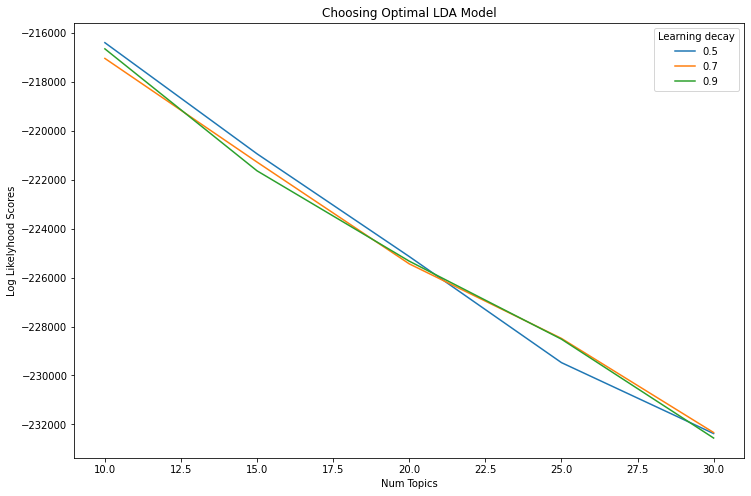

In [19]:
# Get Log Likelyhoods from Grid Search Output
n_topics = [10, 15, 20, 25, 30]
log_likelyhoods_5 = [round(gscore) for ind, gscore in enumerate(model.cv_results_['mean_test_score']) if ind <= 4]
log_likelyhoods_7 = [round(gscore) for ind, gscore in enumerate(model.cv_results_['mean_test_score']) if ind > 4 and ind < 10]
log_likelyhoods_9 = [round(gscore) for ind, gscore in enumerate(model.cv_results_['mean_test_score']) if ind >= 10]

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

### Dominant topic of each document

In [20]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(df1['article']))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,dominant_topic
Doc0,0.000000,0.000000,0.000000,0.000000,0.930000,0.050000,0.000000,0.000000,0.000000,0.000000,4
Doc1,0.000000,0.000000,0.000000,0.000000,0.990000,0.000000,0.000000,0.000000,0.000000,0.000000,4
Doc2,0.000000,0.000000,0.000000,0.000000,0.990000,0.000000,0.000000,0.000000,0.000000,0.000000,4
Doc3,0.000000,0.000000,0.000000,0.000000,0.740000,0.000000,0.060000,0.190000,0.000000,0.000000,4
Doc4,0.000000,0.000000,0.000000,0.160000,0.000000,0.350000,0.000000,0.490000,0.000000,0.000000,7
Doc5,0.370000,0.000000,0.000000,0.250000,0.110000,0.030000,0.000000,0.020000,0.000000,0.210000,0
Doc6,0.000000,0.000000,0.000000,0.000000,0.990000,0.000000,0.000000,0.000000,0.000000,0.000000,4
Doc7,0.000000,0.000000,0.000000,0.000000,0.990000,0.000000,0.000000,0.000000,0.000000,0.000000,4
Doc8,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4
Doc9,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4


In [21]:
# Review topics distribution across documents
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,3,204
1,4,202
2,7,95
3,0,71
4,1,51
5,6,36
6,5,34
7,9,26
8,8,17
9,2,8


### PyLDavis visualization

- A good topic model will have non-overlapping, fairly big sized blobs for each topic. This seems to be the case here. So, we are good.

In [22]:
import pyLDAvis.gensim
import gensim
pyLDAvis.enable_notebook()

In [23]:
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
4     -21.398722  -9.930348       1        1  29.205575
3      37.782555   7.271980       2        1  18.458168
7       4.364703  11.833390       3        1  16.693869
1     -28.809189  19.060810       4        1   8.629204
0     -12.119336 -38.375179       5        1   7.686371
6      28.493076  35.715893       6        1   7.533118
5      12.012806 -14.490602       7        1   6.028617
9      45.179039 -21.724873       8        1   2.673014
8      -4.209752  41.327240       9        1   1.626068
2      20.581852 -43.987083      10        1   1.465996, topic_info=         Term         Freq        Total Category  logprob  loglift
1125      say  2712.000000  2712.000000  Default  30.0000  30.0000
235   company  1548.000000  1548.000000  Default  29.0000  29.0000
300     crude   425.000000   425.000000  Default  28.0000  28.0000
1067   report   759.000000   759.000000  Default  27.0000  27.0000
109    barrel   612.000000   612.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
1433     year    12.828112  1652.728657  Topic10  -4.6688  -0.6359
552       gas    11.850354  1034.849101  Topic10  -4.7481  -0.2470
1162    share    10.196140   409.523018  Topic10  -4.8984   0.5297
606      hold     8.734238   204.352983  Topic10  -5.0532   1.0700
1319     time     8.508417   305.565278  Topic10  -5.0794   0.6415

[625 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
5         3  0.026216  accident
5         7  0.943784  accident
6         1  0.133914    accord
6         2  0.068674    accord
6         3  0.206022    accord
...     ...       ...       ...
1434      2  0.054153     yield
1434      3  0.270764     yield
1434      9  0.324916     yield
1434     10  0.054153     yield
1435      3  0.959955     young

[1855 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 8, 2, 1, 7, 6, 10, 9, 3])

### Topic's keyword

In [24]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords

,able,absolutely,accelerate,accept,access,accident,accord,account,accuse,achieve,...,world,worldwide,worry,worth,write,writing,wrong,year,yield,young
Topic0,0.100012,0.100001,0.100002,0.100206,6.344797,0.100012,98.507855,0.100044,0.100039,1.840466,...,7.705903,0.100005,0.100004,0.167944,6.470660,0.100014,0.100019,24.904153,0.100001,0.100000
Topic1,4.129490,1.806704,0.100086,3.429388,0.102156,0.477904,25.936839,6.376459,0.100013,8.161572,...,70.144567,1.390717,0.100008,3.544513,0.100014,0.100035,0.100011,100.154561,0.100051,0.100011
Topic2,2.933468,0.100000,0.100000,0.100030,0.100005,0.100000,12.083969,1.100008,0.100005,1.460207,...,13.946687,1.978683,0.100005,0.100004,0.100040,3.757435,0.100000,13.619740,0.949191,0.100000
Topic3,1.814380,0.100010,6.775276,4.761729,4.671842,0.100001,19.474209,12.760262,0.100019,4.462379,...,62.192691,6.333689,0.100004,9.214905,19.868267,14.097978,0.100005,281.654322,1.371158,0.100001
Topic4,23.795207,0.100001,8.884098,0.100002,0.100010,0.100001,40.116577,7.156540,0.100004,7.728213,...,31.631307,0.100235,9.481408,36.467183,18.616040,9.227541,5.370267,811.094547,5.269837,0.100001
Topic5,0.100048,0.100020,0.100016,0.100018,0.100025,36.255078,20.458436,0.100066,9.169369,0.100003,...,9.532025,0.100005,0.100015,0.100034,0.100026,0.100010,0.100027,36.308399,0.100039,0.100004
Topic6,8.768406,4.401503,0.100014,0.100004,0.100024,0.100001,11.440969,19.017251,0.100006,0.100015,...,81.760846,7.373160,6.097388,0.100008,0.100700,0.316900,0.100016,130.364505,0.100019,0.100006
Topic7,5.158982,9.091747,0.100004,17.108562,7.281133,0.566997,60.247576,6.581585,18.299095,2.551868,...,30.885939,2.423393,3.721141,9.105367,50.498984,0.100074,12.829655,248.014427,4.780199,19.099968
Topic8,0.100003,0.100005,0.100000,0.100000,0.100002,0.100000,0.566282,0.100004,0.831440,0.100000,...,0.100010,0.100011,0.100008,0.100017,13.025044,0.100001,0.100000,11.654729,6.129500,0.100000
Topic9,0.100003,0.100009,3.640504,0.100061,0.100006,0.100006,8.167287,2.707781,0.100010,1.495277,...,0.100026,0.100102,0.100018,0.100025,0.120225,0.100011,0.100000,23.230617,0.100006,0.100010


From the above output, I want to see the top 15 keywords that are representative of the topic.

In [25]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,crude,say,oil,barrel,pipeline,refinery,accord,source,cargo,trading,market,fuel,sell,supply,comment
Topic 1,say,emission,gas,climate,carbon,company,energy,oil,investor,year,target,renewable,investment,fuel,global
Topic 2,reserve,claim,oil,complaint,barrel,estimate,firm,allege,say,company,pressure,report,world,year,cent
Topic 3,say,gas,oil,year,company,field,production,project,new,exploration,offshore,deal,develop,investment,stake
Topic 4,oil,year,say,percent,price,company,quarter,barrel,report,production,share,cost,profit,rise,expect
Topic 5,spill,say,company,oil,court,federal,safety,rule,state,claim,disaster,environmental,lawsuit,site,water
Topic 6,demand,say,energy,percent,year,growth,oil,fuel,global,grow,world,market,car,expect,increase
Topic 7,oil,say,year,company,work,government,people,museum,group,make,tell,report,change,time,protest
Topic 8,say,report,company,block,make,share,oil,statement,decision,industry,issue,comment,investor,payment,allege
Topic 9,lng,say,company,term,tax,contract,market,agreement,coverage,oil,trade,source,text,report,expect


### Training a Supervised Classifier

#### Converting topics to feature vectors

In [26]:
# Create Document - Topic Matrix
X_num_topic = best_lda_model.transform(data_vectorized)
len(X_num_topic)

744

#### Lets get y for classifier like in Milestone 3

In [27]:
y = df1['Close']
len(y)

744

In [28]:
# Need an indicator to see whether there is
# a positive or negative growth 

# How

# Proposal: we have 2 categories: positive, negative

# pos = 1
# neg = 0


y_dummy = []

# pos: 
for ind in range(len(y)-1): 
    if y[ind] < y[ind+1]:
        val = 0
        y_dummy.append(val)
    
    else:
        val2 = 1
        y_dummy.append(val2)

# add value to last row as  y[ind] < y[ind+1] doesnt work there:
y_dummy.append(1)

In [29]:
len(y_dummy)

744

#### Metrics

In [30]:
# Import metrics
from sklearn.metrics import (precision_score, recall_score, f1_score, 
                             confusion_matrix, accuracy_score, roc_curve, auc, roc_auc_score)

from sklearn.model_selection import train_test_split

### Split  Data Randomized

In [31]:
# randomized splitting data

X = X_num_topic # the features we want to analyze
y = y_dummy # the labels, or answers, we want to test against

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 1)

#### Logistic Regression

In [32]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(C=1, random_state= 0)

In [33]:
# fit
classifier.fit(X_train, y_train)

# model predictions
y_pred_test = classifier.predict(X_test)
y_pred_train = classifier.predict(X_train)

# metrics
print('train score: {:.2f}%'.format(100*classifier.score(X_train, y_train)))
print('test score: {:.2f}%'.format(100*classifier.score(X_test, y_test)))
print()
print('F1 score on training: {:.2f}%'.format(100*f1_score(y_train, y_pred_train)))
print()
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred_test))

train score: 75.80%
test score: 71.14%

F1 score on training: 86.23%

Confusion Matrix
[[  0  43]
 [  0 106]]


C:\Users\gehwo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Lets play with the classification weight parameters:

In [34]:
C_values = [0.01, 0.1, 1, 10, 100, 1000]
penalty_values = ['l1', 'l2']

print()
for norm in penalty_values:
    print('# Norm ', norm)
    print()
    for C in C_values:
        print('## C: ', C)
        # Note: increase max iterations 10x for solver's convergence
        classifier = LogisticRegression(C=C, penalty=norm, dual=False, max_iter=10000)
        classifier.fit(X_train, y_train)
        print('test score: {:.2f}%'.format(100*classifier.score(X_test, y_test)))
        print('train score: {:.2f}%'.format(100*classifier.score(X_train, y_train)))
        # print('weights: ', classifier.coef_[0])
    print()


# Norm  l1

## C:  0.01
test score: 71.14%
train score: 75.80%
## C:  0.1
test score: 71.14%
train score: 75.80%
## C:  1
test score: 71.14%
train score: 75.80%
## C:  10
test score: 71.14%
train score: 75.80%
## C:  100
test score: 71.14%
train score: 75.80%
## C:  1000
test score: 71.14%
train score: 75.80%

# Norm  l2

## C:  0.01
test score: 71.14%
train score: 75.80%
## C:  0.1
test score: 71.14%
train score: 75.80%
## C:  1
test score: 71.14%
train score: 75.80%
## C:  10
test score: 71.14%
train score: 75.80%
## C:  100
test score: 71.14%
train score: 75.80%
## C:  1000
test score: 71.14%
train score: 75.80%



C:\Users\gehwo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\gehwo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\gehwo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\gehwo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\gehwo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

#### Nearest Neighbors

In [35]:
from sklearn.neighbors import KNeighborsClassifier

# Let's use 5 neighbors to learn
classifier = KNeighborsClassifier(n_neighbors=5)

# fit
classifier.fit(X_train, y_train)

# model predictions
y_pred_test = classifier.predict(X_test)
y_pred_train = classifier.predict(X_train)

# metrics
print('train score: {:.2f}%'.format(100*classifier.score(X_train, y_train)))
print('test score: {:.2f}%'.format(100*classifier.score(X_test, y_test)))
print()
print('F1 score on training: {:.2f}%'.format(100*f1_score(y_train, y_pred_train)))
print()
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred_test))

train score: 79.16%
test score: 63.76%

F1 score on training: 87.37%

Confusion Matrix
[[ 2 41]
 [13 93]]


In [36]:
# Changing the parameters
n_neighbors_list = [1, 10, 100]
p_list = [1, 2] #1=Manhatan distance norm ; 2=Euclidian distance

print()
for p in p_list:
    print()
    print('# Distance ', p)
    print()
    for n_neighbors in n_neighbors_list:
        print('## Nb neighbors: ', n_neighbors)
        # Note: increase max iterations 10x for solver's convergence
        classifier = KNeighborsClassifier(n_neighbors=n_neighbors, p=p)
        
        classifier.fit(X_train, y_train)
        
        
        print('train score: {:.2f}%'.format(100*classifier.score(X_train, y_train)))
        print('test score: {:.2f}%'.format(100*classifier.score(X_test, y_test)))
        # print('weights: ', classifier.coef_[0])



# Distance  1

## Nb neighbors:  1
train score: 96.81%
test score: 65.10%
## Nb neighbors:  10
train score: 77.31%
test score: 69.80%
## Nb neighbors:  100
train score: 75.80%
test score: 71.14%

# Distance  2

## Nb neighbors:  1
train score: 96.81%
test score: 65.77%
## Nb neighbors:  10
train score: 77.31%
test score: 71.14%
## Nb neighbors:  100
train score: 75.80%
test score: 71.14%


### Linear SVM

In [37]:
from sklearn.svm import LinearSVC

In [38]:
classifier = LinearSVC(C=1)

# fit
classifier.fit(X_train, y_train)

# model predictions
y_pred_test = classifier.predict(X_test)
y_pred_train = classifier.predict(X_train)

# metrics
print('train score: {:.2f}%'.format(100*classifier.score(X_train, y_train)))
print('test score: {:.2f}%'.format(100*classifier.score(X_test, y_test)))
print()
print('F1 score on training: {:.2f}%'.format(100*f1_score(y_train, y_pred_train)))
print()
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred_test))

train score: 75.80%
test score: 71.14%

F1 score on training: 86.23%

Confusion Matrix
[[  0  43]
 [  0 106]]


### Kernel based SVM

In [39]:
from sklearn.svm import SVC

classifier = SVC(kernel='rbf', gamma=20)

# fit
classifier.fit(X_train, y_train)

# model predictions
y_pred_test = classifier.predict(X_test)
y_pred_train = classifier.predict(X_train)

# metrics
print('train score: {:.2f}%'.format(100*classifier.score(X_train, y_train)))
print('test score: {:.2f}%'.format(100*classifier.score(X_test, y_test)))
print()
print('F1 score on training: {:.2f}%'.format(100*f1_score(y_train, y_pred_train)))
print()
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred_test))

train score: 78.49%
test score: 71.14%

F1 score on training: 87.55%

Confusion Matrix
[[  0  43]
 [  0 106]]


##### Find optimal  `gamma`


In [40]:
kernel = 'rbf'
gammas = [0.05, 0.5, 5, 50, 'scale',]

for i, gamma in enumerate(gammas):
    classifier = SVC(kernel=kernel, gamma=gamma)
    classifier.fit(X_train, y_train)
    print('##gamma= {}'.format(gamma))
    print('train score: {:.2f}%'.format(100*classifier.score(X_train, y_train)))
    print('test score: {:.2f}%'.format(100*classifier.score(X_test, y_test)))
    print()

##gamma= 0.05
train score: 75.80%
test score: 71.14%

##gamma= 0.5
train score: 75.80%
test score: 71.14%

##gamma= 5
train score: 75.97%
test score: 71.14%

##gamma= 50
train score: 84.87%
test score: 70.47%

##gamma= scale
train score: 75.80%
test score: 71.14%



### Temporal Splitting

In [41]:
# temporal splitting

# create benchmark
bench = int(len(y)*0.8) # 80% of the data

# for the y variable
y_train = y[:bench]
y_test = y[bench:]

# for the X_num variable
X_train = X[:bench]
X_test = X[bench:]

#### Logistic Regression

In [42]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(C=1, random_state= 0)

In [43]:
# fit
classifier.fit(X_train, y_train)

# model predictions
y_pred_test = classifier.predict(X_test)
y_pred_train = classifier.predict(X_train)

# metrics
print('train score: {:.2f}%'.format(100*classifier.score(X_train, y_train)))
print('test score: {:.2f}%'.format(100*classifier.score(X_test, y_test)))
print()
print('F1 score on training: {:.2f}%'.format(100*f1_score(y_train, y_pred_train)))
print()
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred_test))

train score: 72.61%
test score: 81.21%

F1 score on training: 84.07%

Confusion Matrix
[[  1  23]
 [  5 120]]


C:\Users\gehwo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Lets play with the classification weight parameters:

In [44]:
C_values = [0.01, 0.1, 1, 10, 100, 1000]
penalty_values = ['l1', 'l2']

print()
for norm in penalty_values:
    print('# Norm ', norm)
    print()
    for C in C_values:
        print('## C: ', C)
        # Note: increase max iterations 10x for solver's convergence
        classifier = LogisticRegression(C=C, penalty=norm, dual=False, max_iter=10000)
        classifier.fit(X_train, y_train)
        print('test score: {:.2f}%'.format(100*classifier.score(X_test, y_test)))
        print('train score: {:.2f}%'.format(100*classifier.score(X_train, y_train)))
        # print('weights: ', classifier.coef_[0])
    print()


# Norm  l1

## C:  0.01
test score: 83.89%
train score: 72.61%
## C:  0.1
test score: 83.89%
train score: 72.61%
## C:  1
test score: 81.21%
train score: 72.61%
## C:  10
test score: 81.21%
train score: 72.94%
## C:  100
test score: 81.21%
train score: 72.94%
## C:  1000
test score: 81.21%
train score: 72.94%

# Norm  l2

## C:  0.01
test score: 83.89%
train score: 72.61%
## C:  0.1
test score: 83.89%
train score: 72.61%
## C:  1
test score: 81.21%
train score: 72.61%
## C:  10
test score: 81.21%
train score: 72.94%
## C:  100
test score: 81.21%
train score: 72.94%
## C:  1000
test score: 81.21%
train score: 72.94%



C:\Users\gehwo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\gehwo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\gehwo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\gehwo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\gehwo\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence t

#### Nearest Neighbors

In [45]:
from sklearn.neighbors import KNeighborsClassifier

# Let's use 5 neighbors to learn
classifier = KNeighborsClassifier(n_neighbors=5)

# fit
classifier.fit(X_train, y_train)

# model predictions
y_pred_test = classifier.predict(X_test)
y_pred_train = classifier.predict(X_train)

# metrics
print('train score: {:.2f}%'.format(100*classifier.score(X_train, y_train)))
print('test score: {:.2f}%'.format(100*classifier.score(X_test, y_test)))
print()
print('F1 score on training: {:.2f}%'.format(100*f1_score(y_train, y_pred_train)))
print()
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred_test))

train score: 76.97%
test score: 62.42%

F1 score on training: 85.41%

Confusion Matrix
[[ 2 22]
 [34 91]]


In [46]:
# Changing the parameters
n_neighbors_list = [1, 10, 100]
p_list = [1, 2] #1=Manhatan distance norm ; 2=Euclidian distance

print()
for p in p_list:
    print()
    print('# Distance ', p)
    print()
    for n_neighbors in n_neighbors_list:
        print('## Nb neighbors: ', n_neighbors)
        # Note: increase max iterations 10x for solver's convergence
        classifier = KNeighborsClassifier(n_neighbors=n_neighbors, p=p)
        
        classifier.fit(X_train, y_train)
        
        
        print('train score: {:.2f}%'.format(100*classifier.score(X_train, y_train)))
        print('test score: {:.2f}%'.format(100*classifier.score(X_test, y_test)))
        # print('weights: ', classifier.coef_[0])



# Distance  1

## Nb neighbors:  1
train score: 96.30%
test score: 56.38%
## Nb neighbors:  10
train score: 74.45%
test score: 63.09%
## Nb neighbors:  100
train score: 72.61%
test score: 83.89%

# Distance  2

## Nb neighbors:  1
train score: 96.30%
test score: 61.07%
## Nb neighbors:  10
train score: 73.28%
test score: 55.03%
## Nb neighbors:  100
train score: 72.61%
test score: 83.89%


### Linear SVM

In [47]:
from sklearn.svm import LinearSVC

In [48]:
classifier = LinearSVC(C=1)

# fit
classifier.fit(X_train, y_train)

# model predictions
y_pred_test = classifier.predict(X_test)
y_pred_train = classifier.predict(X_train)

# metrics
print('train score: {:.2f}%'.format(100*classifier.score(X_train, y_train)))
print('test score: {:.2f}%'.format(100*classifier.score(X_test, y_test)))
print()
print('F1 score on training: {:.2f}%'.format(100*f1_score(y_train, y_pred_train)))
print()
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred_test))

train score: 72.77%
test score: 81.21%

F1 score on training: 84.15%

Confusion Matrix
[[  1  23]
 [  5 120]]


### Kernel based SVM

In [49]:
from sklearn.svm import SVC

classifier = SVC(kernel='rbf', gamma=20)

# fit
classifier.fit(X_train, y_train)

# model predictions
y_pred_test = classifier.predict(X_test)
y_pred_train = classifier.predict(X_train)

# metrics
print('train score: {:.2f}%'.format(100*classifier.score(X_train, y_train)))
print('test score: {:.2f}%'.format(100*classifier.score(X_test, y_test)))
print()
print('F1 score on training: {:.2f}%'.format(100*f1_score(y_train, y_pred_train)))
print()
print('Confusion Matrix')
print(confusion_matrix(y_test, y_pred_test))

train score: 78.99%
test score: 75.84%

F1 score on training: 87.21%

Confusion Matrix
[[  0  24]
 [ 12 113]]


##### Find optimal  `gamma`


In [50]:
kernel = 'rbf'
gammas = [0.05, 0.5, 5, 50, 'scale',]

for i, gamma in enumerate(gammas):
    classifier = SVC(kernel=kernel, gamma=gamma)
    classifier.fit(X_train, y_train)
    print('##gamma= {}'.format(gamma))
    print('train score: {:.2f}%'.format(100*classifier.score(X_train, y_train)))
    print('test score: {:.2f}%'.format(100*classifier.score(X_test, y_test)))
    print()

##gamma= 0.05
train score: 72.61%
test score: 83.89%

##gamma= 0.5
train score: 72.61%
test score: 83.89%

##gamma= 5
train score: 73.78%
test score: 76.51%

##gamma= 50
train score: 85.04%
test score: 76.51%

##gamma= scale
train score: 73.11%
test score: 81.21%



## Conclusion

- One gets better results for the temporal splitting for most of the classifier 
  methods